In [3]:
## LIBRERIAS
from google.colab import drive, files
import tensorflow as tf 
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import mlflow
from keras import Model, Sequential
from keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, BatchNormalization, Rescaling, GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
import random
import os
random.seed(1234)

In [ ]:
## Cargamos Drive e importamos las imágenes de train y test
drive.mount('/content/drive')
!unzip "/content/drive/MyDrive/ColabNotebooks/Mineria_Aspectos_Avanzados/Competicion_Kaggle/Sentinel2LULC_354.zip" -d "/content"
!unzip "/content/drive/MyDrive/ColabNotebooks/Mineria_Aspectos_Avanzados/Competicion_Kaggle/Sentinel2LULC_Test.zip" -d "/content"

In [5]:
## Renombramos las carpetas para que tf las lea en orden
dirnames = sorted(os.listdir("Sentinel2LULC_354"))
for dir in dirnames:
  newname = ""

  if (len(dir.split('_')[0]) == 1):
    newname = '0'+dir.split('_')[0]
  else:
    newname = dir.split('_')[0]

  os.rename("Sentinel2LULC_354/"+dir,"Sentinel2LULC_354/"+newname)

In [6]:
## Leemos las imágenes de train, validacion y test

training = tf.keras.utils.image_dataset_from_directory(
  "Sentinel2LULC_354",
  validation_split=0.2,
  subset="training",
  seed=1234,
  image_size=(224, 224),
  batch_size = 32)

validation = tf.keras.utils.image_dataset_from_directory(
  "Sentinel2LULC_354",
  validation_split=0.2,
  subset="validation",
  seed=1234,
  image_size=(224, 224),
  batch_size = 32)

test = tf.keras.utils.image_dataset_from_directory(
  "Sentinel2LULC_Test",
  shuffle=False,
  labels=None,
  image_size=(224, 224),
  batch_size = 32)


Found 10266 files belonging to 29 classes.
Using 8213 files for training.
Found 10266 files belonging to 29 classes.
Using 2053 files for validation.
Found 1618 files belonging to 1 classes.


31801344/31790344 [==============================] - 1s 0us/step


2022/03/15 21:49:19 INFO mlflow.tracking.fluent: Experiment with name 'EfficientNetB2 sin DataAugmentation (ImageNet)' does not exist. Creating a new experiment.


Epoch 1/25
257/257 [==============================] - 87s 257ms/step - loss: 2.5063 - accuracy: 0.5372 - val_loss: 1.3826 - val_accuracy: 0.6050
Epoch 2/25
257/257 [==============================] - 62s 241ms/step - loss: 1.4664 - accuracy: 0.6447 - val_loss: 1.1249 - val_accuracy: 0.6678
Epoch 3/25
257/257 [==============================] - 62s 242ms/step - loss: 1.1238 - accuracy: 0.6846 - val_loss: 1.0455 - val_accuracy: 0.6951
Epoch 4/25
257/257 [==============================] - 62s 241ms/step - loss: 1.0026 - accuracy: 0.6948 - val_loss: 0.9814 - val_accuracy: 0.7073
Epoch 5/25
257/257 [==============================] - 62s 241ms/step - loss: 0.9383 - accuracy: 0.7074 - val_loss: 0.9634 - val_accuracy: 0.7024
Epoch 6/25
257/257 [==============================] - 62s 240ms/step - loss: 0.9352 - accuracy: 0.7051 - val_loss: 1.0123 - val_accuracy: 0.6970
Epoch 7/25
257/257 [==============================] - 62s 240ms/step - loss: 0.9039 - accuracy: 0.7103 - val_loss: 1.0305 - val_ac

2022/03/15 22:00:05 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during tensorflow autologging: 'EarlyStopping' object is not iterable


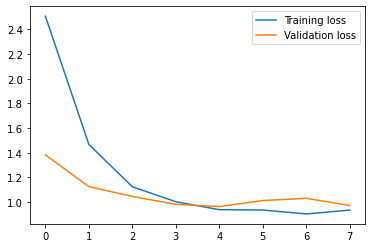

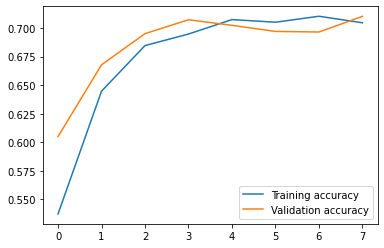

In [7]:
## Función que muestra la evolución de las accuracy de train y validacion
## durante el entrenamiento.
def mostrarEvolucion(hist):

  loss = hist.history['loss']
  val_loss = hist.history['val_loss']
  plt.plot(loss)
  plt.plot(val_loss)
  plt.legend(['Training loss', 'Validation loss'])
  plt.show()

  acc = hist.history['accuracy']
  val_acc = hist.history['val_accuracy']
  plt.plot(acc)
  plt.plot(val_acc)
  plt.legend(['Training accuracy', 'Validation accuracy'])
  plt.show()

## Vamos a entrenar usando la red EfficietNetB2
base_model = tf.keras.applications.EfficientNetB2(input_shape=(224,224,3),
                                               include_top=False,
                                               weights='imagenet',
                                               pooling='avg')

base_model.trainable = False

normalization = Rescaling(1./255)
prediction_layer = Dense(29, activation="softmax")

model = Sequential([
  #normalization,
  base_model,
  BatchNormalization(),
  Dropout(0.2),
  prediction_layer
])

opt = Adam(learning_rate=1e-2)
      
model.compile(loss=SparseCategoricalCrossentropy(from_logits=False),optimizer=opt, 
                  metrics=['accuracy'])

mlflow.set_experiment("EfficientNetB2 sin DataAugmentation (ImageNet)")
mlflow.tensorflow.autolog()

with mlflow.start_run():
  callback = EarlyStopping(patience=3,restore_best_weights=True)
  history = model.fit(training,
                    epochs=25,
                    validation_data=validation,
                    callbacks=callback)

  mostrarEvolucion(history)

Epoch 1/10
257/257 [==============================] - 256s 925ms/step - loss: 1.4333 - accuracy: 0.6078 - val_loss: 2.1736 - val_accuracy: 0.4910
Epoch 2/10
257/257 [==============================] - 235s 912ms/step - loss: 0.6209 - accuracy: 0.7953 - val_loss: 0.5394 - val_accuracy: 0.8339
Epoch 3/10
257/257 [==============================] - 235s 915ms/step - loss: 0.4630 - accuracy: 0.8439 - val_loss: 0.4957 - val_accuracy: 0.8592
Epoch 4/10
257/257 [==============================] - 235s 912ms/step - loss: 0.3339 - accuracy: 0.8837 - val_loss: 0.4562 - val_accuracy: 0.8719
Epoch 5/10
257/257 [==============================] - 235s 913ms/step - loss: 0.2726 - accuracy: 0.9039 - val_loss: 0.4399 - val_accuracy: 0.8695
Epoch 6/10
257/257 [==============================] - 234s 911ms/step - loss: 0.2300 - accuracy: 0.9181 - val_loss: 0.7170 - val_accuracy: 0.8734
Epoch 7/10
257/257 [==============================] - 235s 913ms/step - loss: 0.1864 - accuracy: 0.9347 - val_loss: 0.8040 -

2022/03/15 22:34:29 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during tensorflow autologging: 'EarlyStopping' object is not iterable


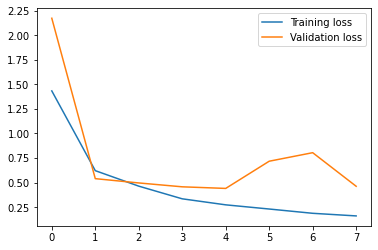

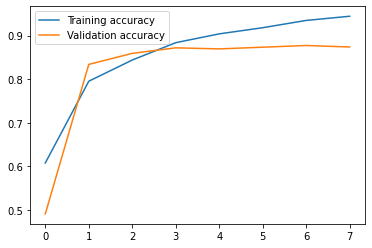

In [8]:
## FINE TUNING: Volvemos a entrenar descongelando algunas capas (menos las BatchNormalization)

def unfreeze_model(model):
    for layer in model.layers[-20:]:
        if not isinstance(layer, BatchNormalization):
            layer.trainable = True

    opt = Adam(learning_rate=1e-4)
    model.compile(loss=SparseCategoricalCrossentropy(from_logits=False),optimizer=opt, 
                  metrics=['accuracy'])


unfreeze_model(model)

with mlflow.start_run():
  callback = EarlyStopping(patience=3,restore_best_weights=True)
  history = model.fit(training,
                    epochs=10,
                    validation_data=validation,
                    callbacks=callback)

  mostrarEvolucion(history)

In [9]:
## Predecimos las clases
y_pred = model.predict(test)
classes = np.argmax(y_pred, axis=1)
classes = np.array(classes)
classes = classes + 1
print(classes)

[10 10 10 ...  9  9 15]


In [11]:
## Creamos el csv con los resultados
d = {'id.jpg': sorted(os.listdir("Sentinel2LULC_Test")), 'label': classes}
df = pd.DataFrame(data=d)
df.to_csv('EfficientNetB2_ImageNet_no_DataAugmentation.csv', index=False)
files.download('EfficientNetB2_ImageNet_no_DataAugmentation.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>